In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from datetime import datetime
from functools import partial
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.filters import gaussian_filter

In [2]:
data_path = 'TaxiData/'
gps_point = pd.read_csv(data_path + 'train_gps_points.csv')
train_df = pd.read_csv(data_path + 'train_hire_stats_new.csv', index_col=0)
test_df = pd.read_csv(data_path + 'test_hire_stats_new.csv', index_col=0)
train_df

Zone_ID        Date  Hour_slot  Hire_count  Temperature     RH  Precp
0             1  2016-02-01          0           0         16.7   76.0    0.0
1             1  2016-02-01          1           0         15.6   92.0    0.0
2             1  2016-02-01          2           0         14.8   98.0    0.0
3             1  2016-02-01          3           0         14.5  100.0    0.0
4             1  2016-02-01          4           0         15.1   99.0    0.0
...         ...         ...        ...         ...          ...    ...    ...
219595       25  2017-01-31         19          26         19.7   85.0    0.0
219596       25  2017-01-31         20          20         19.3   86.0    0.0
219597       25  2017-01-31         21          16         19.3   85.0    0.0
219598       25  2017-01-31         22          14         19.3   84.0    0.0
219599       25  2017-01-31         23          16         19.2   85.0    0.0

[219600 rows x 7 columns]

In [3]:
# Check weekday & workday
# holidays連假的平常日
# workdays連假的補班日

holidays = {
    '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12',
    '2016-02-29', '2016-04-04', '2016-04-05', '2016-6-9', '2016-6-10',
    '2016-09-15', '2016-09-16', '2016-10-10', '2017-01-02', '2017-01-27',
    '2017-01-30', '2017-02-01', '2017-02-27', '2017-02-28'
}
makeupworkdays = {'2016-06-04', '2016-09-10', '2017-02-18'}


def data_engineering(df, holidays, makeupworkdays):
    #Declare weekday & workday
    isworkday = np.ones((len(df), ), dtype=int)
    weekday = np.ones((len(df), ), dtype=int)
    month = np.ones((len(df), ), dtype=int)

    #Compute weekday & workday
    #weekday()
    #0 == Monday, #1 == Tuesday, #2 == Wednesday,  #3 == Thursday,  #4 == Friday,  #5 == Saturday, #6 == Sunday

    for index, row in df.iterrows():
        dd = datetime.strptime(row['Date'], "%Y-%m-%d")
        month[index] = dd.month
        
        if row['Date'] in holidays:
            isworkday[index] = 0
        else:
            weekday[index] = dd.weekday()
            if weekday[index] >= 5 and row['Date'] not in makeupworkdays:
                isworkday[index] = 0

    df['isworkday'] = isworkday
    df['weekday'] = weekday
    df['month'] = month
    return df


train_df = data_engineering(train_df, holidays, makeupworkdays)
test_df = data_engineering(test_df, holidays, makeupworkdays)

train_df

Zone_ID        Date  Hour_slot  Hire_count  Temperature     RH  Precp  \
0             1  2016-02-01          0           0         16.7   76.0    0.0   
1             1  2016-02-01          1           0         15.6   92.0    0.0   
2             1  2016-02-01          2           0         14.8   98.0    0.0   
3             1  2016-02-01          3           0         14.5  100.0    0.0   
4             1  2016-02-01          4           0         15.1   99.0    0.0   
...         ...         ...        ...         ...          ...    ...    ...   
219595       25  2017-01-31         19          26         19.7   85.0    0.0   
219596       25  2017-01-31         20          20         19.3   86.0    0.0   
219597       25  2017-01-31         21          16         19.3   85.0    0.0   
219598       25  2017-01-31         22          14         19.3   84.0    0.0   
219599       25  2017-01-31         23          16         19.2   85.0    0.0   

        isworkday  weekday  month  
0               1        0      2  
1               1        0      2  
2               1        0      2  
3               1        0      2  
4               1        0      2  
...           ...      ...    ...  
219595          1        1      1  
219596          1        1      1  
219597          1        1      1  
219598          1        1      1  
219599          1        1      1  

[219600 rows x 10 columns]

In [4]:
# 檢查是否有空值
np.any(train_df.isna()), np.any(test_df.drop(columns='Hire_count').isna()) 

(False, False)

In [5]:
# testing set 只需要在這幾個區域 infer
test_df['Zone_ID'].unique().tolist()  

[7, 8, 9, 12, 13, 14, 17, 18, 19]

畫一下各區域的租賃資料分布，會發現有幾區特別少

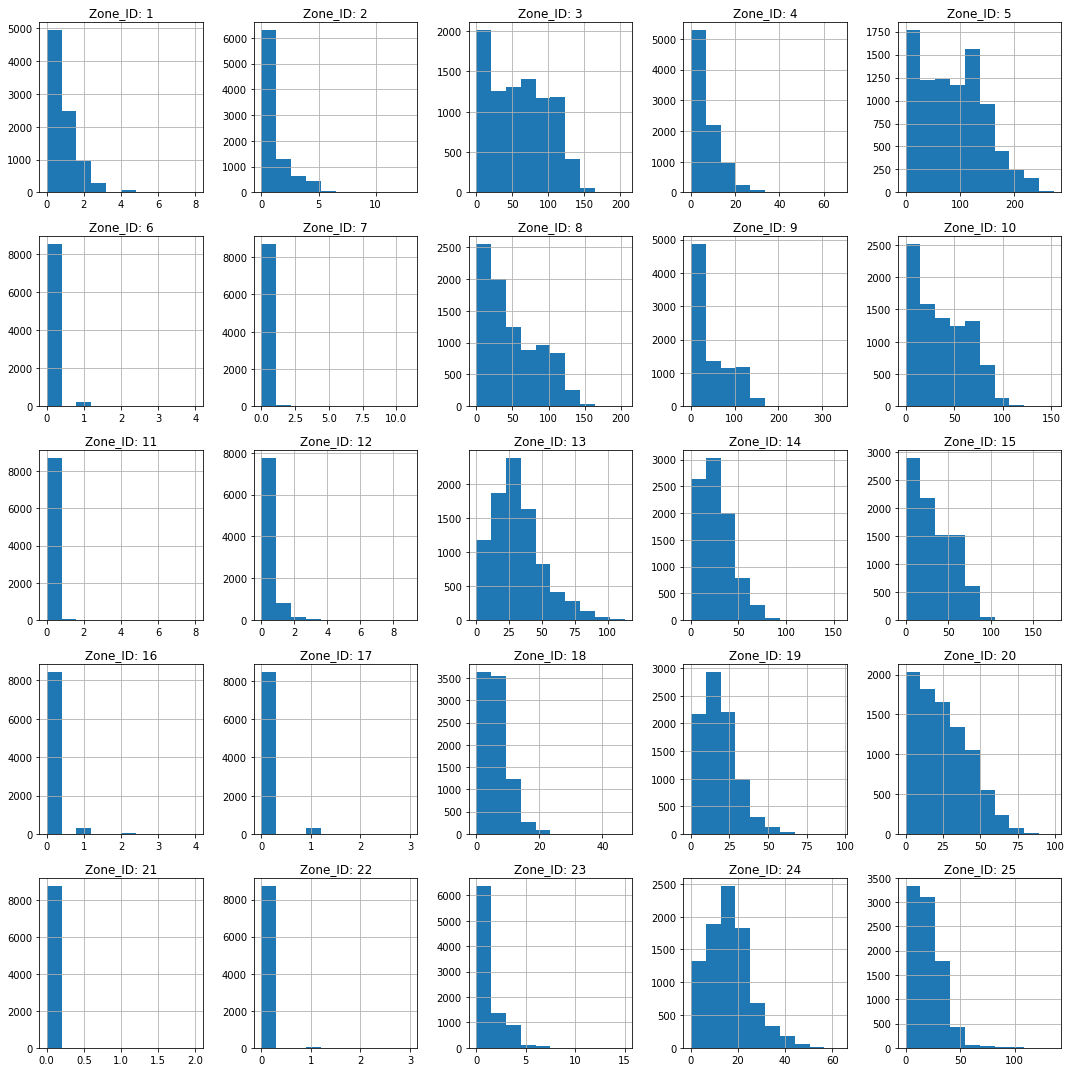

In [6]:
plt.figure(figsize=(15, 15))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.title(f'Zone_ID: {i}')
    train_df.query(f'Zone_ID == {i}').Hire_count.hist()
plt.tight_layout()
plt.show()

如果zone_id 在 7, 12, 17 這三個，如果直接全輸出零，metric (root mean square error) 可以得到不錯的分數

In [7]:
def rmse(preds ,ys): return ((preds - ys) ** 2).mean() ** 0.5
for id_ in [7, 12, 17]:
    label = train_df.query(f'Zone_ID == {id_}').Hire_count.values
    print(rmse(np.zeros(label.shape), label))

0.3336746886028481
0.5360416208727009
0.19587038947162702


從下圖，可以直接看出地區(zone_id)對於hire_count有巨大的影響

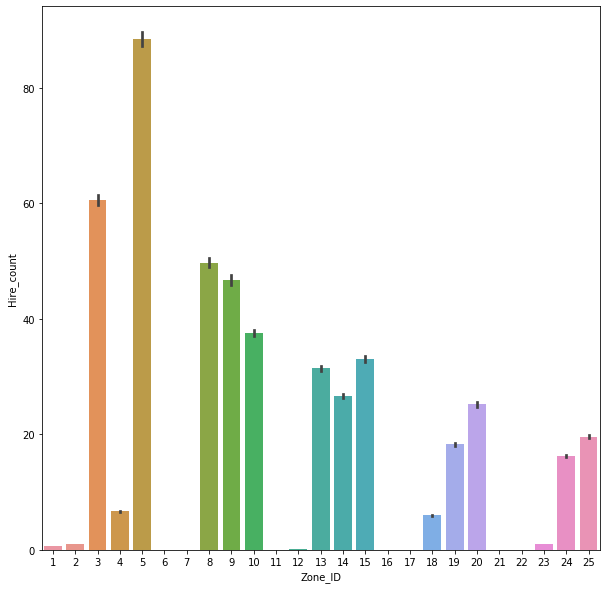

In [11]:
plt.figure(figsize=(10, 10))
sns.barplot(x='Zone_ID', y='Hire_count', data=train_df);

看看連假的補班日對hire的影響

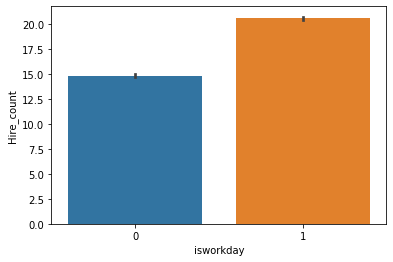

In [14]:
sns.barplot(x='isworkday', y='Hire_count', data=train_df)
plt.show()

再看看各月份對hire的影響。看不太出什麼變化，二月份天數少，又有連假，比較少是正常的

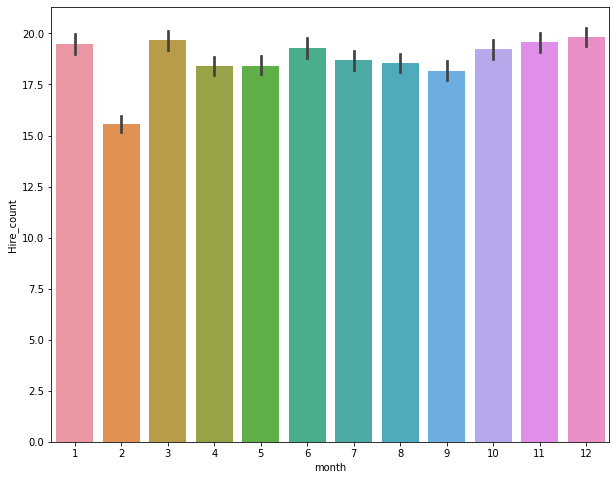

In [15]:
plt.figure(figsize=(10, 8))
sns.barplot(x='month', y='Hire_count', data=train_df)
plt.show()

從下圖可以看出星期日(最右邊)的hire很明顯低於其他天

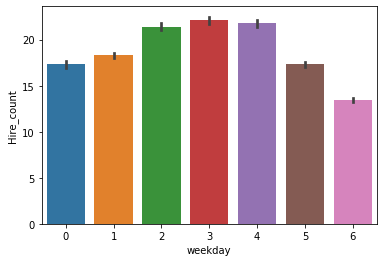

In [16]:
sns.barplot(x='weekday', y='Hire_count', data=train_df)
plt.show()

從下圖，可以直接看出每小時(Hour_slot)對於hire_count有巨大的影響

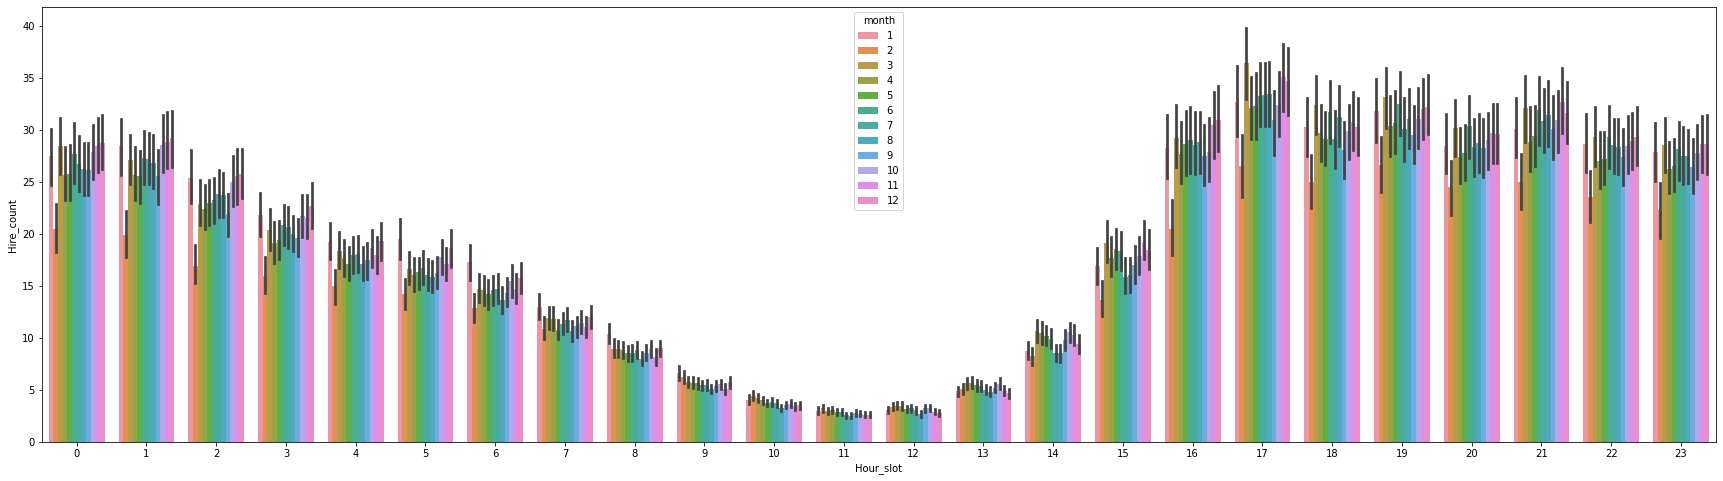

In [17]:
plt.figure(figsize=(30, 8))
sns.barplot(x='Hour_slot', y='Hire_count', hue='month', data=train_df)
plt.show()

從熱力圖看看每小時、月份，對於hire的影響

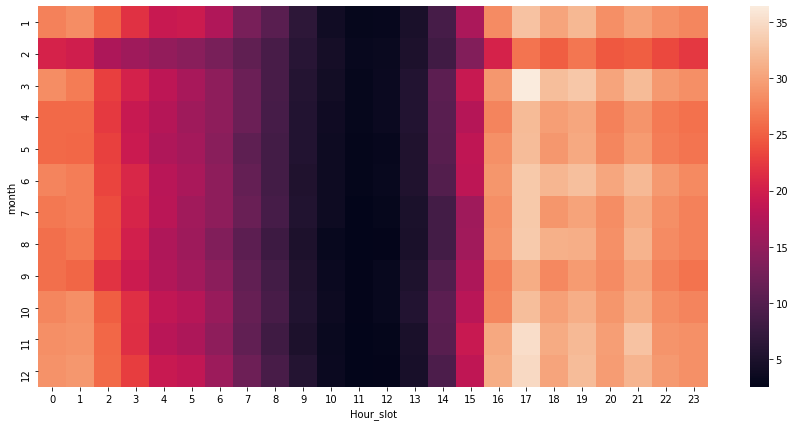

In [18]:
plt.figure(figsize=(15, 7))
piv = pd.pivot_table(train_df,
                     values='Hire_count',
                     index=['month'],
                     columns=['Hour_slot'])
sns.heatmap(piv);

試著以熱力圖與3d模型，畫出在各個區域，每個月分對hire的影響

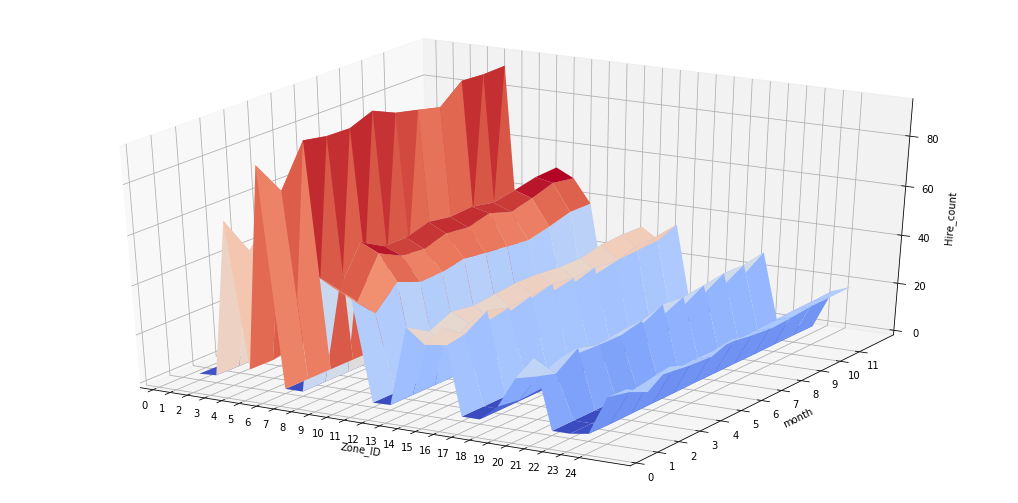

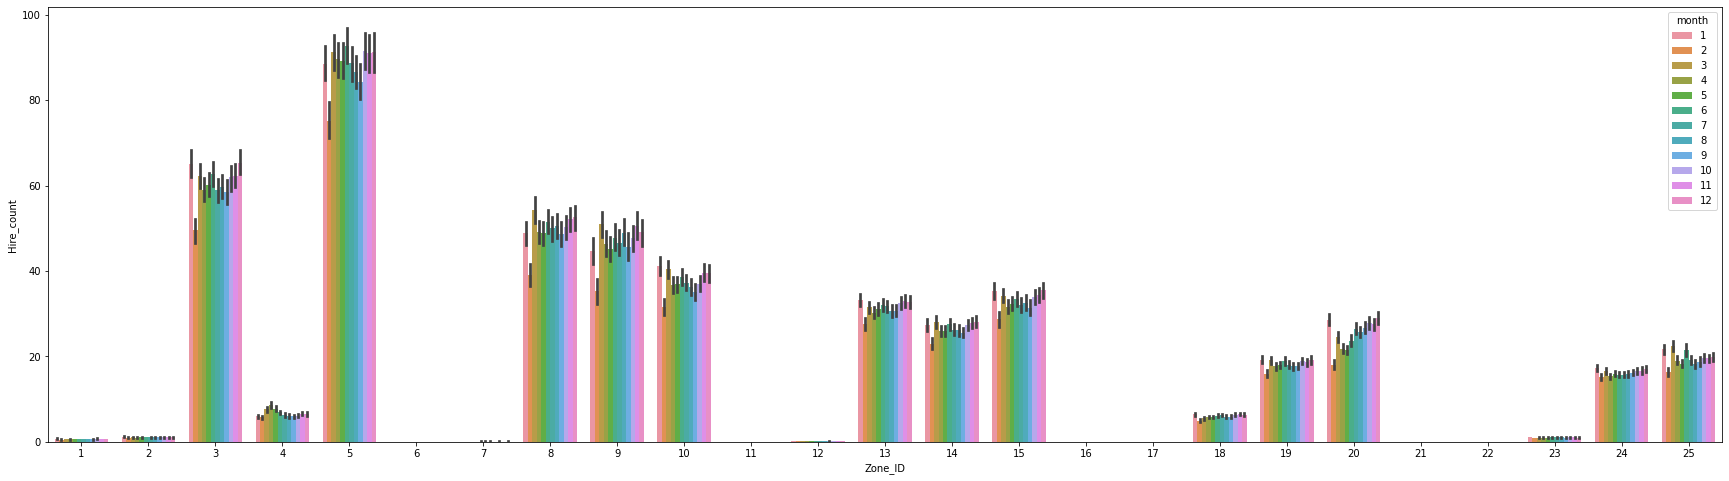

<Figure size 1080x504 with 0 Axes>

In [26]:
# can use this line to become interactive mode
# %matplotlib
values = 'Hire_count'
index = 'month'
columns = 'Zone_ID'
            
plt.figure(figsize=(18, 9))
piv = pd.pivot_table(train_df,
                     values='Hire_count',
                     index=['month'],
                     columns=['Zone_ID'])
X, Y = np.meshgrid(np.array(piv.keys()) - 1, np.array(piv.index) - 1)
Z = piv.values.T[X, Y]
ax = plt.axes(projection="3d")
ax.plot_surface(X + 1, Y + 1, Z, cmap='coolwarm')
ax.set_xticks(range(25))
ax.set_xlabel(columns)
ax.set_yticks(range(12))
ax.set_ylabel(index)
ax.set_zlabel(values)
plt.show()

plt.figure(figsize=(30, 8))
sns.barplot(x='Zone_ID', y='Hire_count', hue='month', data=train_df)
plt.show()


plt.figure(figsize=(15, 7))
piv = pd.pivot_table(train_df,
                     values='Hire_count',
                     index=['month'],
                     columns=['Zone_ID'])
px.imshow(piv)

畫出各區域，每個小時hire的變化

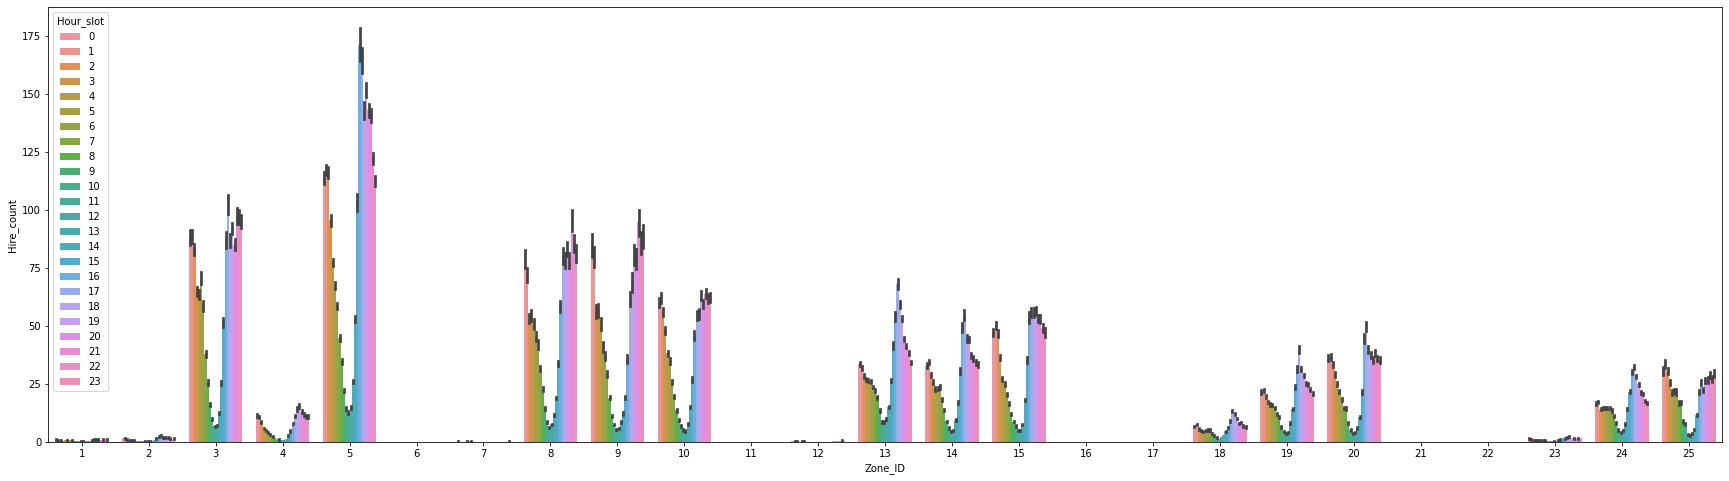

<Figure size 1080x504 with 0 Axes>

In [28]:
plt.figure(figsize=(30, 8))
sns.barplot(x='Zone_ID', y='Hire_count', hue='Hour_slot', data=train_df);
plt.show()

plt.figure(figsize=(15, 7))
piv = pd.pivot_table(train_df,
                     values='Hire_count',
                     index=['Hour_slot'],
                     columns=['Zone_ID'])
px.imshow(piv)

畫出每周，每個時段對hire的變化。用plotly畫出來的圖可以對其互動，看數值，但seaborn畫出來的圖比較好看

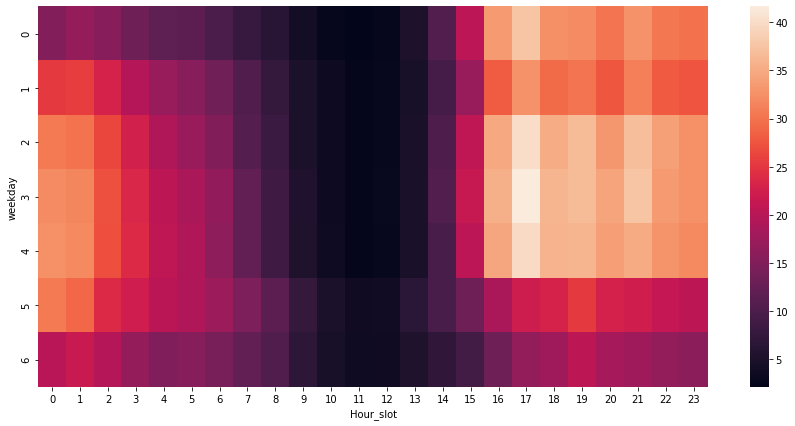

In [29]:
plt.figure(figsize=(15, 7))
piv = pd.pivot_table(train_df,
                     values='Hire_count',
                     index=['weekday'],
                     columns=['Hour_slot'])
sns.heatmap(piv)
px.imshow(piv)

畫出各月份，氣溫分布圖

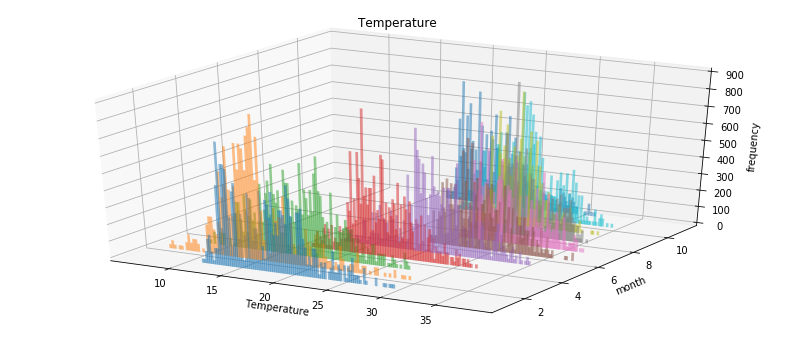

In [46]:
def plot_3dhist(df, col):
    fig = plt.figure(figsize=(14, 6))
    ax = plt.axes(projection="3d")

    for i in range(1, 12, 1):
        value = df.query(f'month == @i')[col].values
        hist, bins = np.histogram(value, bins=100)
        xs = (bins[:-1] + bins[1:]) / 2
        ax.bar(xs, hist, zs=i, zdir='y', alpha=0.5, width=0.25)
    ax.set_xlabel(col)
    ax.set_ylabel('month')
    ax.set_zlabel('frequency')
    plt.title(col)
    plt.show()
    
plot_3dhist(train_df, 'Temperature')

# plot_heatmap with gps_point(raw data)

Datetime  Longitude_X  Latitude_Y  Zone_ID
0        2016-02-01 08:01:10 +08:00   121.590916   25.080958       13
1        2016-02-01 08:01:16 +08:00   121.551468   25.063524        5
2        2016-02-01 08:01:42 +08:00   121.568883   25.068289        9
3        2016-02-01 08:01:59 +08:00   121.559309   25.057847        5
4        2016-02-01 08:02:04 +08:00   121.563837   25.052547        5
...                             ...          ...         ...      ...
4118807  2017-01-31 23:59:25 +08:00   121.603753   25.056671       20
4118808  2017-01-31 23:59:47 +08:00   121.592167   25.086632       13
4118809  2017-01-31 23:59:48 +08:00   121.615473   25.061945       25
4118810  2017-01-31 23:59:50 +08:00   121.592216   25.087894       13
4118811  2017-01-31 23:59:51 +08:00   121.618448   25.072709       24

[4118812 rows x 4 columns]

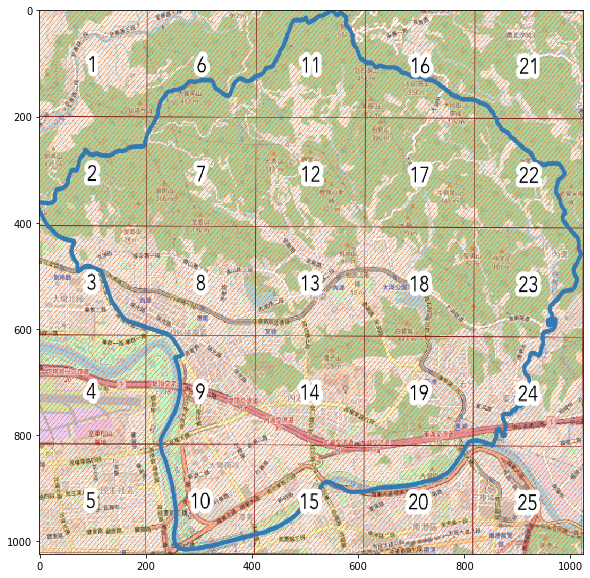

In [31]:
size = 1024

zone_org = cv2.imread(data_path + 'zones_clip.png')[..., ::-1]
zone_org = cv2.resize(zone_org, (size, size))
plt.figure(figsize=(10, 10))
plt.imshow(zone_org)
gps_point

In [32]:
# gps to xy
x = np.array([[121.551408, 121.628658], [1, 1]])
y = np.array([[0, 1]])
func_x = y.dot(np.linalg.inv(x)).ravel()

x = np.array([[25.115518, 25.052083], [1, 1]])
y = np.array([[0, 1]])
func_y = y.dot(np.linalg.inv(x)).ravel()


def gps2xy_(gps, size, func_x, func_y):
    func = np.array([func_x, func_y])
    return (gps * func[:, 0] + func[:, 1]) * size
    return x, y


gps2xy = partial(gps2xy_, size=size, func_x=func_x, func_y=func_y)
points = gps_point[['Longitude_X', 'Latitude_Y']].values
points = gps2xy(points)

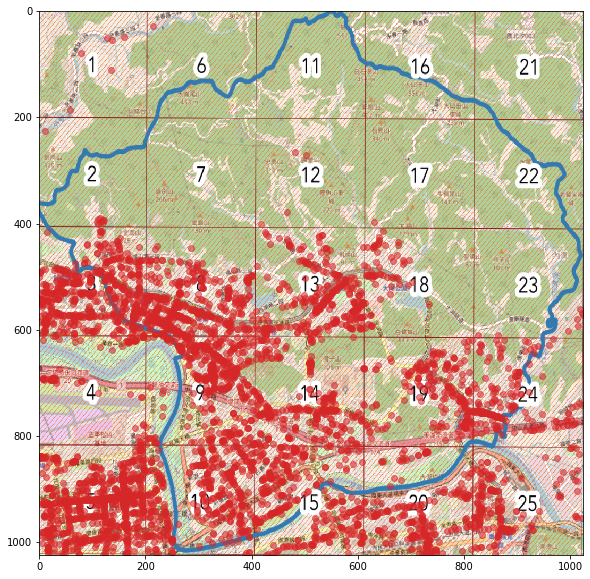

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(zone_org)
index = np.random.choice(range(len(points)), size=5000)
plt.scatter(points[index, 0], points[index, 1], alpha=0.55, c='C3')
plt.xlim([0, 1024])
plt.ylim([1024, 0])
plt.show()

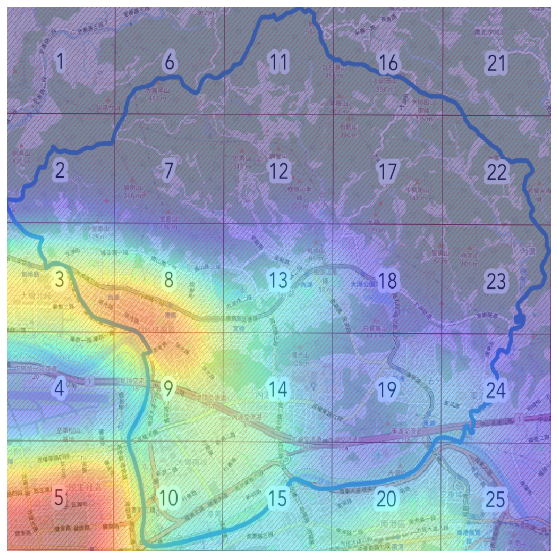

In [34]:
plt.figure(figsize=(10, 10))
heatmap = np.histogram2d(points[:, 0], points[:, 1], bins=1024)[0]
heatmap = gaussian_filter(heatmap, sigma=75)

plt.imshow(heatmap.T, alpha=0.75, cmap='jet')
    
plt.imshow(zone_org, alpha=0.50)
plt.axis('off')
plt.show()

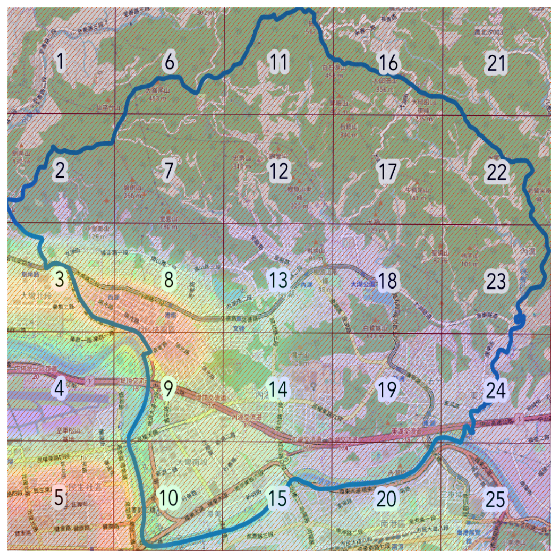

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = np.histogram2d(points[:, 0], points[:, 1], bins=1024)[0]
heatmap = gaussian_filter(heatmap, sigma=75)

plt.pcolormesh(heatmap.T, cmap='jet', shading='gouraud', alpha=0.01)
fig.canvas.draw()
    
plt.imshow(zone_org, alpha=1.0)
plt.axis('off')
plt.show()

## 使用folium熱力圖

In [36]:
import folium
from folium.plugins import HeatMap

center_location = [25.0838005, 121.590033]

fmap = folium.Map(location=center_location,
                  max_zoom=13,
                  min_zoom=13,
                  max_bounds=True,
                  min_lat=25.052083,
                  max_lat=25.115518,
                  min_lon=121.551408,
                  max_lon=121.628658)

points = gps_point[['Latitude_Y', 'Longitude_X']].values
points = points[np.random.choice(range(len(gps_point)), size=1000)]
HeatMap(
    points,
    min_opacity=0.5,
    radius=25,
    blur=25,
).add_to(fmap)
fmap

畫出各月份熱力圖的變化

In [37]:
import re

import folium
from folium.plugins import HeatMapWithTime

center_location = [25.0838005, 121.590033]

fmap = folium.Map(location=center_location,
                  max_zoom=13,
                  min_zoom=13,
                  max_bounds=True,
                  min_lat=25.052083,
                  max_lat=25.115518,
                  min_lon=121.551408,
                  max_lon=121.628658)



gps_point['month'] = gps_point.Datetime.apply(
lambda x: int(re.search(r'-(\d+)-', x).group(1)))

points = []
for m in range(1, 13):
    points.append(gps_point.query(f'month == @m')[['Latitude_Y', 'Longitude_X']].sample(1000).values.tolist())
    
HeatMapWithTime(points).add_to(fmap)
fmap